# Compare GC to NOAA MBL sites

[NOAA Global Monitoring Laboratory](https://www.gml.noaa.gov)

baseline observatory sites are given in file `NOAA_MBL_sites.txt` and at [NOAA Greenhouse Gas Marine Boundary Layer Reference](https://gml.noaa.gov/ccgg/mbl/map.php?param=CH4)

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# file pattern for GEOS-Chem ObsPack output files
gcstr = './posterior_run/OutputDir/GEOSChem.ObsPack.%Y%m%d_0000z.nc4'

# File pattern for processed obspack data
obstr = './obspack/obspack_ch4.%Y%m%d.nc'

In [3]:
keepv = [
    'time',
    'value',
    'latitude',
    'longitude',
    'altitude',
    'platform',
    'utc_conv',
    'CT_sampling_strategy',
    'obspack_id',
    'obs_flag',
    'qcflag'
]

In [ ]:
# get obs and some needed variables, convert to dataframe
def getday(mydate):
    janobs = xr.open_dataset(mydate.strftime(obstr)) # ObsPack observation for each day
    jangc = xr.open_dataset(mydate.strftime(gcstr)) # GEOS-Chem observation for each day
    jandf = janobs[keepv].to_dataframe()
    gcdf = jangc[['CH4']].to_dataframe()
    jandf['gcCH4'] = gcdf*1e9 # convert to ppb
    jandf['obspack_id'] = jandf['obspack_id'].str.decode('utf-8')
    jandf['sitecode'] = jandf['obspack_id'].str.split('~').str[1].str.split('_').str[1]
    jandf['dataset'] = jandf['obspack_id'].str.split('~').str[1]
    jandf['LST'] = jandf['time']+pd.to_timedelta(jandf["utc_conv"].values,unit='h')
    jandf['value'] *= 1e9
    jandf = jandf.rename(columns={'value':'opCH4'})
    janobs.close()
    jangc.close()
    return jandf

In [5]:
ihavefile = True # obs already paired and in csv

In [ ]:
if ihavefile:
    mdf = pd.read_csv('./obspack_ch4_2019_posterior.csv',index_col=0,parse_dates=[1,15])
else:
    dailydfs = []
    # loop through each day in the year and get the ObsPack and GEOS-Chem data for each day as a df
    for myday in pd.date_range('2019-01-01','2019-12-31',freq='D'):
        print(f'\r{myday.strftime("%Y-%m-%d")}   ',end='')
        dailydfs.append(getday(myday))
    # concat to single df
    mdf = pd.concat(dailydfs)
    # remove unphysical
    mdf = mdf.query('(opCH4 > 500) and (gcCH4 > 500)').copy()
    mdf.to_csv('./obspack_ch4_2019_posterior.csv') # merged ObsPack and GEOS-Chem data for each day in the year BEFORE additional filtering and averaging

Filter like [Lu et al., 2021](https://doi.org/10.5194/acp-21-4637-2021)

In [7]:
with open('NOAA_MBL_sites.txt') as mblsitesfile:
    mblsites = [s.strip().lower() for s in mblsitesfile]

In [8]:
# sites used in NOAA MBL reference also in obspack
keepsites = sorted(list(set(mblsites) & set(mdf.sitecode.unique())))

In [ ]:
# subset for background sites daytime
bgdf = mdf[mdf['sitecode'].isin(keepsites)]
# keep only daytime data for in situ sites, and keep flask sites
tmask = (
    (
        bgdf['dataset'].str.contains('insitu') & # hourly monitoring
        (bgdf['LST'].dt.hour >= 10) &
        (bgdf['LST'].dt.hour <= 16)
    ) |
    bgdf['dataset'].str.contains('flask')
)

# representative of regional background (obs flag of 1)
repmask = (
    bgdf['obs_flag'] == np.float64(1.)
)

bgdf = bgdf[(tmask & repmask)] 

In [ ]:
# compute mean and 3 std for each observation site
gb = bgdf[['opCH4','dataset']].groupby('dataset')
sd3 = gb.std().rename(columns={'opCH4':'3SD'})
sd3 *= 3
sitemean = gb.mean().rename(columns={'opCH4':'sitemean'})
bgdf = bgdf.merge(sitemean,on='dataset').merge(sd3,on='dataset')
# remove > 3 std from mean
bgdff = bgdf.query((
    '(opCH4 <= (sitemean + `3SD`)) & '
    '(opCH4 >= (sitemean - `3SD`))'
)).copy()

In [ ]:
# keep only flask sites (more reliable for background measurements)
bgdff = bgdff.loc[bgdff.dataset.str.contains('flask'),:]

In [ ]:
# group the filtered data and compute mean for each group
bgdff['yyyymmdd'] = bgdff.time.dt.strftime('%Y%m%d')
smean = bgdff.groupby(['sitecode','yyyymmdd','dataset']).mean(numeric_only=True).reset_index()

In [13]:
smean['date'] = pd.to_datetime(smean['yyyymmdd'])
#smean = smean.merge(labdf,on='dataset')

In [14]:
#sitedf = mdf[mdf['sitecode'].isin(keepsites)][['latitude','longitude','sitecode']].groupby('sitecode').first()
sitedf = bgdff[['latitude','longitude','dataset','sitecode']].groupby('dataset').first()

In [15]:
sitedf

,latitude,longitude,sitecode
dataset,,,
ch4_alt_surface-flask_1_representative,82.4508,-62.5072,alt
ch4_alt_surface-flask_2_representative,82.4508,-62.5072,alt
ch4_asc_surface-flask_1_representative,-7.9667,-14.4000,asc
ch4_bmw_surface-flask_1_representative,32.2647,-64.8788,bmw
ch4_brw_surface-flask_1_representative,71.3230,-156.6114,brw
ch4_cba_surface-flask_1_representative,55.2100,-162.7200,cba
ch4_cgo_surface-flask_1_representative,-40.6830,144.6900,cgo
ch4_cgo_surface-flask_2_representative,-40.6830,144.6890,cgo
ch4_chr_surface-flask_1_representative,1.7000,-157.1518,chr


In [16]:
cidx = np.linspace(16,256-16,num=len(keepsites),dtype=int)

In [17]:
for s in keepsites:
    print(s,end=' ')

alt asc bmw brw cba cgo chr crz eic gmi hba ice key kum mhd mid psa rpb shm smo spo syo ush zep 

In [18]:
colorlist = ['#ffffcc','#c2e699','#78c679','#238443']
sitecolors = dict(zip(keepsites,colorlist[::-1]))
sitefull = [
    'Alert', # Canada',
    'Ascension Island', # United Kingdom',
    'Tudor Hill', # Bermuda',
    'Barrow', # AK',
    'Cold Bay', # AK',
    'Cape Grim', # Tasmania',
    'Christmas Island', # republic of kiribati,
    'Crozet Island',#france
    'Easter Island', #chile
    'Mariana Islands', #guam
    'Halley Station', #antarctica UK
    'Storhofdi', #Vestmannaeyjar, Iceland
    'Key Biscayne', #Florida, United States
    'Cape Kumukahi', #Hawaii, United States
    'Mace Head', #County Galway, Ireland
    'Sand Island', #Midway, United States
    'Palmer Station', #Antarctica, United States
    'Ragged Point', #Barbados
    'Shemya Island', #Alaska, United States
    'Samoa', #Tutuila, American Samoa
    'South Pole', #Antarctica, United States
    'Syowa Station', #Antarctica, Japan
    'Ushuaia', #Argentina
    'Ny-Alesund', #Svalbard, Norway and Sweden
]
sitenames = dict(zip(keepsites,sitefull))

In [19]:
sitedf_quick = sitedf.groupby('sitecode').first()
sitedf_quick = sitedf_quick.sort_values('latitude',ascending=False)
for sn in sitedf_quick.index:
    print(sitenames[sn],sitedf_quick.loc[sn]['longitude'],sitedf_quick.loc[sn]['latitude'])

Alert -62.5072 82.4508
Ny-Alesund 11.8883 78.9067
Barrow -156.6114 71.323
Storhofdi -20.2884 63.3998
Cold Bay -162.72 55.21
Mace Head -9.899 53.326
Shemya Island 174.126 52.7112
Tudor Hill -64.8788 32.2647
Sand Island -177.38 28.21
Key Biscayne -80.158 25.6654
Cape Kumukahi -155.0116 19.7371
Mariana Islands 144.656 13.386
Ragged Point -59.432 13.165
Christmas Island -157.1518 1.7
Ascension Island -14.4 -7.9667
Samoa -170.5644 -14.2474
Easter Island -109.4284 -27.1597
Cape Grim 144.69 -40.683
Crozet Island 51.8478 -46.4337
Ushuaia -68.3106 -54.8484
Palmer Station -64.0527 -64.7742
Syowa Station 39.59 -69.0125
Halley Station -26.21 -75.605
South Pole -24.8 -89.98


In [20]:
smean['type'] = smean.dataset.str.split('_').str[2].str.split('-').str[1]

In [ ]:
# final processed output with daily mean CH4 (representative observations within 3std of mean)
smean.to_csv('obspack_ch4_2019_processed_posterior.csv')

sites with > 2000 ppb:  [['brw'], ['cba', 'cba'], ['key', 'key', 'key', 'key', 'key', 'key', 'key', 'key', 'key', 'key', 'key', 'key', 'key', 'key']]


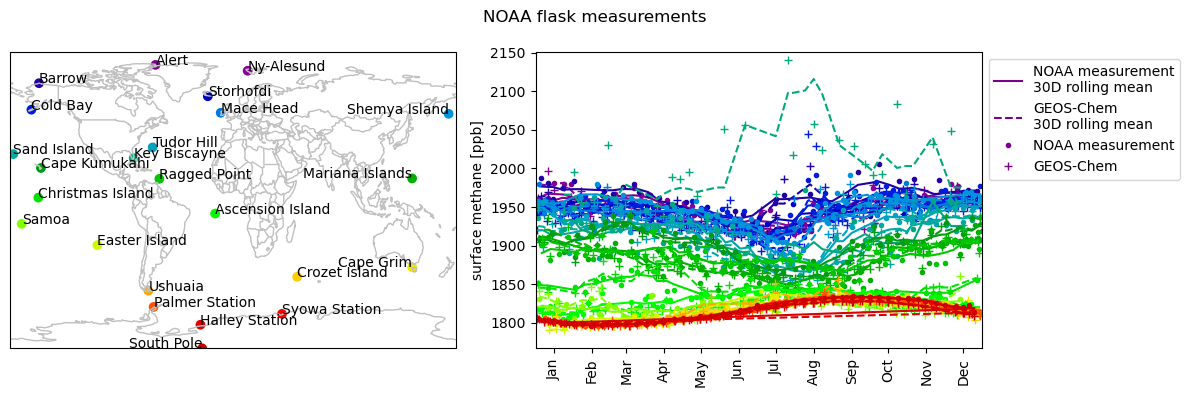

In [22]:
roller = '30D'
cmapp = 'nipy_spectral'
fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(1, 4)
ax1 = fig.add_subplot(gs[0:2], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[2:])

outliers = []

mnths = pd.date_range('2019-01-01','2019-12-31',freq='MS')+pd.Timedelta('15D') # monthly ticks (mid-month)
for i,s in enumerate(sitedf_quick.index): # iterates over site data, each has NOAA obs and GC methane data
    if i == 0:
        labels = [f'NOAA measurement\n{roller} rolling mean',f'GEOS-Chem\n{roller} rolling mean']
        labs2 = ['NOAA measurement','GEOS-Chem']
    else:
        labels = [None,None]
        labs2 = [None,None]
    
    myfilter = ( # keep only NOAA flask measurements for current site
        (smean['sitecode'] == s) &
        #(smean['lab'] == 'NOAA') & 
        (smean['type'] == 'flask')
    )
    # rolling average
    mydata_smooth = smean[myfilter].set_index('date').sort_values('date').rolling(roller,center=True).mean(numeric_only=True).reset_index()
    # original data filtered for the site
    mydata = smean[myfilter].set_index('date').sort_values('date').reset_index() 

    ax2.plot(mydata_smooth['date'],mydata_smooth['opCH4'],'-',c=plt.get_cmap(cmapp)(cidx[i]),label=labels[0])
    ax2.plot(mydata_smooth['date'],mydata_smooth['gcCH4'],'--',c=plt.get_cmap(cmapp)(cidx[i]),label=labels[1])
    ax2.plot(mydata['date'],mydata['opCH4'],'.',c=plt.get_cmap(cmapp)(cidx[i]),label=labs2[0])
    ax2.plot(mydata['date'],mydata['gcCH4'],'+',c=plt.get_cmap(cmapp)(cidx[i]),label=labs2[1])

    high_ch4 = mydata[mydata['gcCH4'] > 2000]
    if high_ch4['sitecode'].values.size != 0:
        outliers.append(high_ch4['sitecode'].values.tolist())

ax2.legend(bbox_to_anchor=(1,1),loc='upper left')
ax2.set_ylim(None,2150)
ax2.set_xticks(ticks=mnths, labels=mnths.strftime('%b'),rotation=90)
ax2.set_xlim(mnths[0]-pd.Timedelta('15D'),mnths[-1]+pd.Timedelta('15D'))
ax2.set_ylabel('surface methane [ppb]')

# map with site locations
ax1.add_feature(cfeature.COASTLINE, edgecolor='silver')
ax1.add_feature(cfeature.BORDERS, edgecolor='silver')
ax1.set_global()  # Sets the map to cover the whole globe
ax1.set_aspect('auto')

ax1.scatter(
    sitedf_quick['longitude'],sitedf_quick['latitude'],
    color=[plt.get_cmap(cmapp)(ii) for ii in cidx],
    transform=ccrs.PlateCarree()
)
ax1.set(ylabel='latitude',xlabel='longitude')


# add annotations with site name
for sn in sitedf_quick.index:
    if sn in ['spo','shm','gmi','cgo']:
        alignment = 'right'
    else:
        alignment = 'left'
    ax1.annotate(
        sitenames[sn],
        (sitedf_quick.loc[sn]['longitude'], sitedf_quick.loc[sn]['latitude']),
        ha=alignment,
        transform=ccrs.PlateCarree()
    )

print('sites with > 2000 ppb: ', outliers)

fig.subplots_adjust(wspace=0.5)
fig.suptitle('NOAA flask measurements')
fig.tight_layout()
#fig.savefig(f'figs/NOAA_MBLref_withGC_allsites_2019_{roller}rollingmean_timeseries.png',bbox_inches='tight',dpi=300)
plt.show()

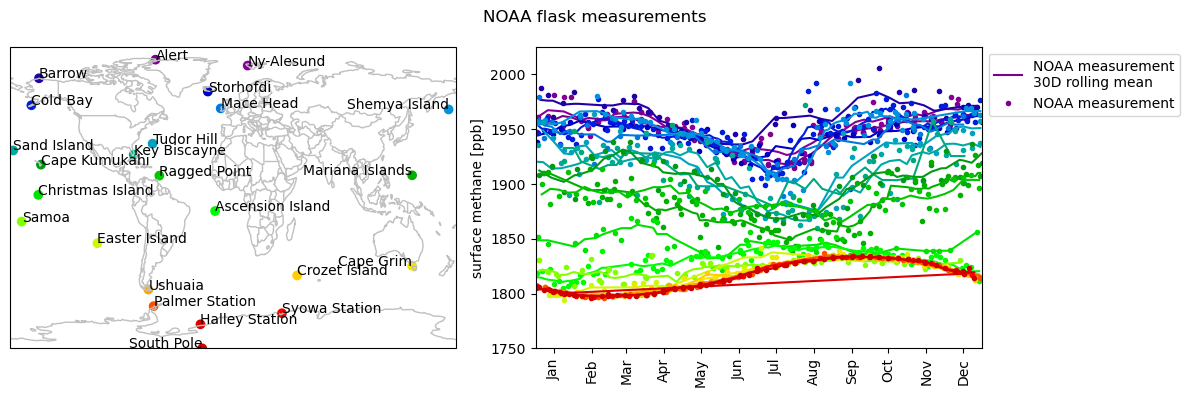

In [23]:
roller = '30D'
cmapp = 'nipy_spectral'
fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(1, 4)
ax1 = fig.add_subplot(gs[0:2], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[2:])

mnths = pd.date_range('2019-01-01','2019-12-31',freq='MS')+pd.Timedelta('15D') # monthly ticks (mid-month)
for i,s in enumerate(sitedf_quick.index):
    if i == 0:
        labels = [f'NOAA measurement\n{roller} rolling mean',f'GEOS-Chem\n{roller} rolling mean']
        labs2 = ['NOAA measurement','GEOS-Chem']
    else:
        labels = [None,None]
        labs2 = [None,None]
    
    myfilter = ( # keep only NOAA flask measurements
        (smean['sitecode'] == s) &
        #(smean['lab'] == 'NOAA') & 
        (smean['type'] == 'flask')
    )
    mydata_smooth = smean[myfilter].set_index('date').sort_values('date').rolling(roller,center=True).mean(numeric_only=True).reset_index()
    mydata = smean[myfilter].set_index('date').sort_values('date').reset_index()
    ax2.plot(mydata_smooth['date'],mydata_smooth['opCH4'],'-',c=plt.get_cmap(cmapp)(cidx[i]),label=labels[0])
    #ax2.plot(mydata_smooth['date'],mydata_smooth['gcCH4'],'--',c=plt.get_cmap(cmapp)(cidx[i]),label=labels[1])
    ax2.plot(mydata['date'],mydata['opCH4'],'.',c=plt.get_cmap(cmapp)(cidx[i]),label=labs2[0])
    #ax2.plot(mydata['date'],mydata['gcCH4'],'+',c=plt.get_cmap(cmapp)(cidx[i]),label=labs2[1])
ax2.legend(bbox_to_anchor=(1,1),loc='upper left')
ax2.set_ylim(1750,2025)
ax2.set_xticks(ticks=mnths, labels=mnths.strftime('%b'),rotation=90)
ax2.set_xlim(mnths[0]-pd.Timedelta('15D'),mnths[-1]+pd.Timedelta('15D'))
ax2.set_ylabel('surface methane [ppb]')

# map with site locations
ax1.add_feature(cfeature.COASTLINE, edgecolor='silver')
ax1.add_feature(cfeature.BORDERS, edgecolor='silver')
ax1.set_global()  # Sets the map to cover the whole globe
ax1.set_aspect('auto')

ax1.scatter(
    sitedf_quick['longitude'],sitedf_quick['latitude'],
    color=[plt.get_cmap(cmapp)(ii) for ii in cidx],
    transform=ccrs.PlateCarree()
)
ax1.set(ylabel='latitude',xlabel='longitude')

# add annotations with site name
for sn in sitedf_quick.index:
    if sn in ['spo','shm','gmi','cgo']:
        alignment = 'right'
    else:
        alignment = 'left'
    ax1.annotate(
        sitenames[sn],
        (sitedf_quick.loc[sn]['longitude'], sitedf_quick.loc[sn]['latitude']),
        ha=alignment,
        transform=ccrs.PlateCarree()
    )

fig.subplots_adjust(wspace=0.5)
fig.suptitle('NOAA flask measurements')
fig.tight_layout()
#fig.savefig(f'figs/NOAA_MBLref_withGC_allsites_2019_{roller}rollingmean_timeseries.png',bbox_inches='tight',dpi=300)
plt.show()

## Quick look at some biases

In [24]:
smean['gcminusop'] = smean['gcCH4'] - smean['opCH4']

In [25]:
latbins = [-90, -15, 10, 35, 90] #np.arange(-90,95,30)
lonbins = np.arange(-180,185,60)
sbylat = smean.where(lambda x: x.type == 'flask').dropna().groupby(['date',pd.cut(smean.latitude,latbins)]).mean(numeric_only=True).dropna()[['opCH4','gcCH4','gcminusop']].reset_index()
sbylon = smean.where(lambda x: x.type == 'flask').dropna().groupby(['date',pd.cut(smean.longitude,lonbins)]).mean(numeric_only=True).dropna()[['opCH4','gcCH4','gcminusop']].reset_index()

/tmp/ipykernel_2546799/440233271.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sbylat = smean.where(lambda x: x.type == 'flask').dropna().groupby(['date',pd.cut(smean.latitude,latbins)]).mean(numeric_only=True).dropna()[['opCH4','gcCH4','gcminusop']].reset_index()
/tmp/ipykernel_2546799/440233271.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sbylon = smean.where(lambda x: x.type == 'flask').dropna().groupby(['date',pd.cut(smean.longitude,lonbins)]).mean(numeric_only=True).dropna()[['opCH4','gcCH4','gcminusop']].reset_index()


## Drop Key site

In [26]:
# TEST: drop Key site

smean_nokey = smean[smean['sitecode'] != 'key']

latbins = [-90, -15, 10, 35, 90] #np.arange(-90,95,30)
lonbins = np.arange(-180,185,60)
sbylat = smean_nokey.where(lambda x: x.type == 'flask').dropna().groupby(['date',pd.cut(smean_nokey.latitude,latbins)]).mean(numeric_only=True).dropna()[['opCH4','gcCH4','gcminusop']].reset_index()
sbylon = smean_nokey.where(lambda x: x.type == 'flask').dropna().groupby(['date',pd.cut(smean_nokey.longitude,lonbins)]).mean(numeric_only=True).dropna()[['opCH4','gcCH4','gcminusop']].reset_index()

/tmp/ipykernel_2546799/1791438625.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sbylat = smean_nokey.where(lambda x: x.type == 'flask').dropna().groupby(['date',pd.cut(smean_nokey.latitude,latbins)]).mean(numeric_only=True).dropna()[['opCH4','gcCH4','gcminusop']].reset_index()
/tmp/ipykernel_2546799/1791438625.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sbylon = smean_nokey.where(lambda x: x.type == 'flask').dropna().groupby(['date',pd.cut(smean_nokey.longitude,lonbins)]).mean(numeric_only=True).dropna()[['opCH4','gcCH4','gcminusop']].reset_index()


In [27]:
cidx = np.linspace(16,256-16,num=len(sbylat.latitude.unique()),dtype=int)

### Plot obs

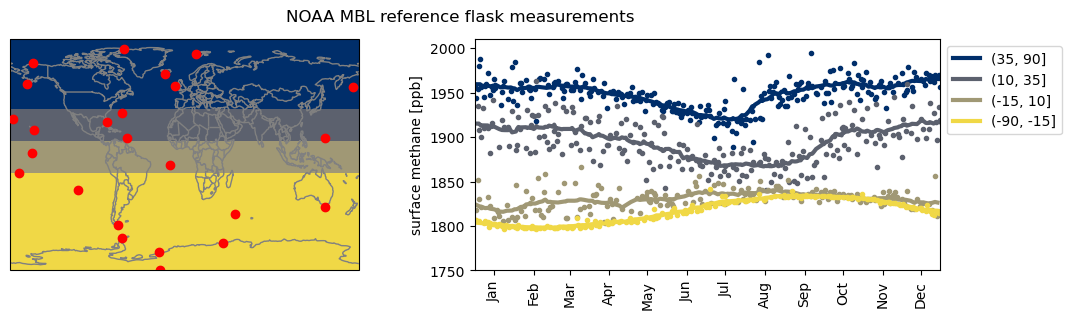

In [28]:
roller = '30D'
cmapp='cividis'
cidx = np.linspace(16,256-16,num=len(sbylat.latitude.unique()),dtype=int)

fig = plt.figure(figsize=(12,3))
gs = fig.add_gridspec(1, 3, width_ratios=[2, 1, 1])
ax1 = fig.add_subplot(gs[0:1], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1:])

mnths = pd.date_range('2019-01-01','2019-12-31',freq='MS')+pd.Timedelta('15D')

for i,bn in enumerate(sorted(sbylat.latitude.unique())[::-1]):
    mydata = sbylat[sbylat['latitude'] == bn]#.sort_values('yyyymmdd')
    mydata_smooth = sbylat[sbylat['latitude'] == bn].set_index('date').sort_values('date').rolling(roller,center=True).mean(numeric_only=True).reset_index()
    ax2.plot(mydata.date, mydata.opCH4,label=None,marker='.',ls='none',c=plt.get_cmap(cmapp)(cidx[i]))
    ax2.plot(mydata_smooth.date, mydata_smooth.opCH4,label=bn,marker=None,ls='-',lw=3,c=plt.get_cmap(cmapp)(cidx[i]))
    ax1.fill_between([-180,180],bn.left,bn.right,color=plt.get_cmap(cmapp)(cidx[i]))
    
ax2.legend(bbox_to_anchor=(1,1),loc='upper left')
ax2.set_ylim(1750,2010)
ax2.set_xticks(ticks=mnths, labels=mnths.strftime('%b'),rotation=90)
ax2.set_xlim(mnths[0]-pd.Timedelta('15D'),mnths[-1]+pd.Timedelta('15D'))
ax2.set_ylabel('surface methane [ppb]')

# map with site locations
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.set_global()  # Sets the map to cover the whole globe
ax1.set_aspect('auto')

ax1.scatter(
    sitedf_quick['longitude'],sitedf_quick['latitude'],
    color='red', zorder=10
)
ax1.set(ylabel='latitude',xlabel='longitude')

fig.subplots_adjust(wspace=0.5)
fig.suptitle('NOAA MBL reference flask measurements')
#fig.savefig(f'figs/MBLref_2019_{roller}rollingmean_timeseries_latbands.png',bbox_inches='tight',dpi=300)
plt.show()

### Plot GC

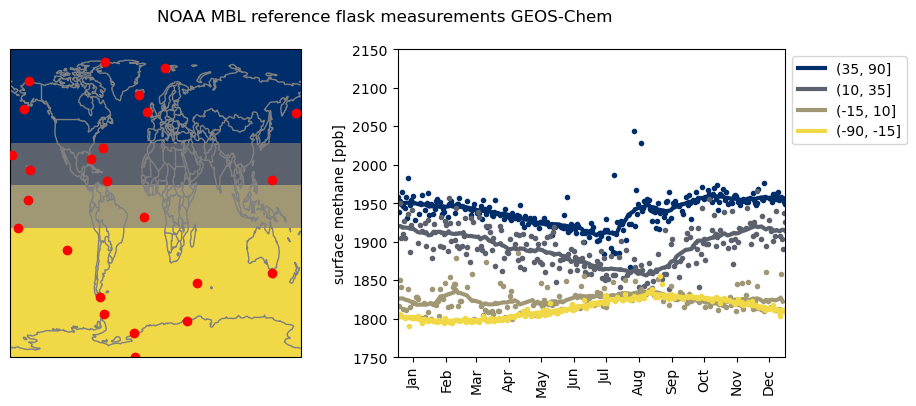

In [29]:
roller = '30D'
cmapp='cividis'
cidx = np.linspace(16,256-16,num=len(sbylat.latitude.unique()),dtype=int)

fig = plt.figure(figsize=(10,4))
gs = fig.add_gridspec(1, 3, width_ratios=[2, 1, 1])
ax1 = fig.add_subplot(gs[0:1], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1:])

mnths = pd.date_range('2019-01-01','2019-12-31',freq='MS')+pd.Timedelta('15D')

for i,bn in enumerate(sorted(sbylat.latitude.unique())[::-1]):
    mydata = sbylat[sbylat['latitude'] == bn]#.sort_values('yyyymmdd')
    mydata_smooth = sbylat[sbylat['latitude'] == bn].set_index('date').sort_values('date').rolling(roller,center=True).mean(numeric_only=True).reset_index()
    ax2.plot(mydata.date, mydata.gcCH4,label=None,marker='.',ls='none',c=plt.get_cmap(cmapp)(cidx[i]))
    ax2.plot(mydata_smooth.date, mydata_smooth.gcCH4,label=bn,marker=None,ls='-',lw=3,c=plt.get_cmap(cmapp)(cidx[i]))
    ax1.fill_between([-180,180],bn.left,bn.right,color=plt.get_cmap(cmapp)(cidx[i]))
    
ax2.legend(bbox_to_anchor=(1,1),loc='upper left')
ax2.set_ylim(1750,2150)
ax2.set_xticks(ticks=mnths, labels=mnths.strftime('%b'),rotation=90)
ax2.set_xlim(mnths[0]-pd.Timedelta('15D'),mnths[-1]+pd.Timedelta('15D'))
ax2.set_ylabel('surface methane [ppb]')

# map with site locations
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.set_global()  # Sets the map to cover the whole globe
ax1.set_aspect('auto')

ax1.scatter(
    sitedf_quick['longitude'],sitedf_quick['latitude'],
    color='red', zorder=10
)
ax1.set(ylabel='latitude',xlabel='longitude')

fig.subplots_adjust(wspace=0.5)
fig.suptitle('NOAA MBL reference flask measurements GEOS-Chem')
#fig.savefig(f'figs/MBLref_2019_{roller}rollingmean_timeseries_latbands.png',bbox_inches='tight',dpi=300)
plt.show()

### Plot GC - obs bias

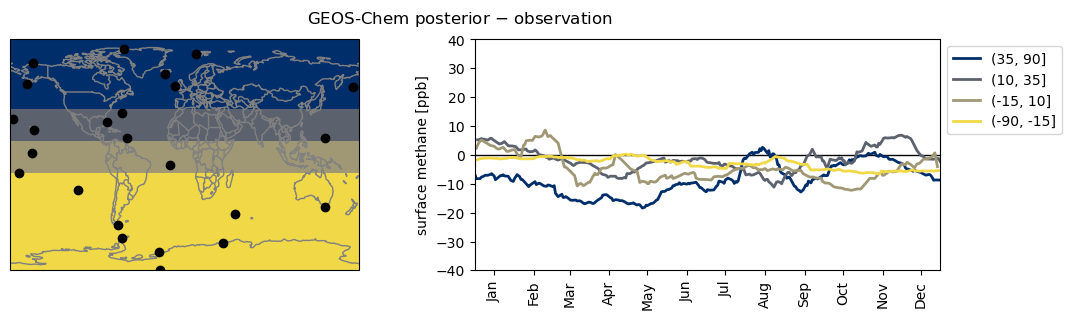

In [30]:
roller = '30D'
cmapp='cividis'
cidx = np.linspace(16,256-16,num=len(sbylat.latitude.unique()),dtype=int)

fig = plt.figure(figsize=(12,3))
gs = fig.add_gridspec(1, 3, width_ratios=[2, 1, 1])
ax1 = fig.add_subplot(gs[0:1], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1:])

mnths = pd.date_range('2019-01-01','2019-12-31',freq='MS')+pd.Timedelta('15D')

for i,bn in enumerate(sorted(sbylat.latitude.unique())[::-1]):
    mydata = sbylat[sbylat['latitude'] == bn]#.sort_values('yyyymmdd')
    mydata_smooth = sbylat[sbylat['latitude'] == bn].set_index('date').sort_values('date').rolling(roller,center=True).mean(numeric_only=True).reset_index()
    #ax2.plot(mydata.date, mydata.gcminusop,label=None,marker='+',ls='none',c=plt.get_cmap(cmapp)(cidx[i]))
    ax2.plot(mydata_smooth.date, mydata_smooth.gcminusop,label=bn,marker=None,ls='-',lw=2,c=plt.get_cmap(cmapp)(cidx[i]))
    ax1.fill_between([-180,180],bn.left,bn.right,color=plt.get_cmap(cmapp)(cidx[i]))
    
ax2.legend(bbox_to_anchor=(1,1),loc='upper left')
#ax2.set_ylim(1750,2010)
ax2.set_xticks(ticks=mnths, labels=mnths.strftime('%b'),rotation=90)
ax2.set_xlim(mnths[0]-pd.Timedelta('15D'),mnths[-1]+pd.Timedelta('15D'))
ax2.set_ylim(-40,40)
ax2.set_ylabel('surface methane [ppb]')

# map with site locations
ax1.add_feature(cfeature.COASTLINE, edgecolor='grey')
ax1.add_feature(cfeature.BORDERS, edgecolor='grey')
ax1.set_global()  # Sets the map to cover the whole globe
ax1.set_aspect('auto')

ax1.scatter(
    sitedf_quick['longitude'],sitedf_quick['latitude'],
    color='k', zorder=10
)
ax2.axhline(0,color='k',lw=1,zorder=0)
ax1.set(ylabel='latitude',xlabel='longitude')

fig.subplots_adjust(wspace=0.5)
fig.suptitle('GEOS-Chem posterior $-$ observation')
#fig.savefig(f'figs/MBLref_GCobsdiff_2019_{roller}rollingmean_timeseries_latbands.png',bbox_inches='tight',dpi=300)
plt.show()

In [33]:
# Compute the yearly average for each latitude band
mean_diff_yearly = sbylat.groupby('latitude')['gcminusop'].mean().reset_index()

print(mean_diff_yearly)


     latitude  gcminusop
0  (-90, -15]  -3.039015
1   (-15, 10]  -4.421525
2    (10, 35]  -1.740905
3    (35, 90]  -8.566442


/tmp/ipykernel_2546799/2730177820.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_diff_yearly = sbylat.groupby('latitude')['gcminusop'].mean().reset_index()
